# Debris removal

This notebook is meant to compute the size threshold separating debris from nuclei using the `tilesegment` package.

Import packages, load segmentation model and define input and output paths

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from tilesegment import rotating_calipers, get_outlines_masks_labels, compute_closest_larger_multiple, tif_reader_5D, get_file_names
import numpy as np

# ### LOAD STARDIST MODEL ###
from stardist.models import StarDist2D
model = StarDist2D.from_pretrained('2D_versatile_fluo')

from csbdeep.utils import normalize
import matplotlib as mpl
plt.rcParams.update({
    "text.usetex": True,
})
mpl.rcParams['text.latex.preamble'] = r'\usepackage{siunitx} \sisetup{detect-all} \usepackage{helvet} \usepackage{sansmath} \sansmath'
mpl.rc('font', size=18) 
mpl.rc('axes', labelsize=18) 
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rc('legend', fontsize=18) 

### PATH TO YOU DATA FOLDER AND TO YOUR SAVING FOLDERS ###
path_data='/path/to/data/'
path_save='/path/to/segmentation/results/'
path_figures = '/path/to/figures/folder/'

2025-10-24 14:41:38.950688: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-24 14:41:38.951810: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-24 14:41:38.973171: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-24 14:41:38.973732: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-24 14:41:39.404883: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


2025-10-24 14:41:39.864255: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-24 14:41:39.867138: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


For this example, we will only use the first repeat to compute the size threshold.

In [2]:
### GET FULL FILE NAME AND FILE CODE ###
files = get_file_names(path_data)

files1 = [file for file in files if "dox_Nanog_1" in file]
files2 = [file for file in files if "dox_Nanog_2" in file]
files3 = [file for file in files if "dox_Nanog_3" in file]
file_hoechst = [f for f in files1 if "ch00" in f][0]
file_nanog = [f for f in files1 if "ch01" in f][0]
file_perk = [f for f in files1 if "ch02" in f][0]
file_gata6 = [f for f in files1 if "ch03" in f][0]

### LOAD HYPERSTACKS ###
IMGS_h, metadata=  tif_reader_5D(path_data+file_hoechst)
IMG_h = np.max(IMGS_h[0,:4, 0].astype("int32"), axis=0)
IMG_h = np.where(IMG_h <= 255, IMG_h, 255).astype("uint8")

IMGS_n, metadata = tif_reader_5D(path_data+file_nanog)
IMG_n = np.max(IMGS_n[0,:4, 0].astype("int32"), axis=0)
IMG_n = np.where(IMG_n <= 255, IMG_n, 255).astype("uint8")


IMGS_p, metadata = tif_reader_5D(path_data+file_perk)
IMG_p = np.max(IMGS_p[0,:4, 0].astype("int32"), axis=0)
IMG_p = np.where(IMG_p <= 255, IMG_p, 255).astype("uint8")


IMGS_g, metadata = tif_reader_5D(path_data+file_gata6)
IMG_g = np.max(IMGS_g[0,:4, 0].astype("int32"), axis=0)
IMG_g = np.where(IMG_g <= 255, IMG_g, 255).astype("uint8")

xyres=metadata["XYresolution"]
try: 
    xyresdif = np.abs(np.abs(xyres[0]) - np.abs(xyres[1]))
    print("xyres dif =", xyresdif)
    xyres = np.mean(xyres)
except: 
    pass


         raw array with shape (10, 2788, 2781)
         returning array with shape (1, 10, 1, 2788, 2781)
         raw array with shape (10, 2788, 2781)
         returning array with shape (1, 10, 1, 2788, 2781)
         raw array with shape (10, 2788, 2781)
         returning array with shape (1, 10, 1, 2788, 2781)
         raw array with shape (10, 2788, 2781)
         returning array with shape (1, 10, 1, 2788, 2781)


Define tiling information: 

* `Ts` = Tile size
* `D` = Image size after squaring the image and making int multiple of Ts
* `O` = Overlap based on cell nuclei. For example 3 times the mean cell nuclei as observed using the remove debrie script
* `Tso` = Tile size with overlap
* `DO` = total image size with overlap
* `n` = number of tiles in a row or column
* `N` = total number of tiles

In [3]:

### TILING ###

# Tile size
Ts = 1024

# Define overlap by running a segmentation test and checking mean cell diameter after removing small objects
# Total image size
sh = IMG_h.shape
D = compute_closest_larger_multiple(max(sh), Ts)

# indexed to be used for image reconstruction
ishdiff = D-sh[0]
top_ishdiff = np.int32(np.ceil(ishdiff/2))
bot_ishdiff = np.int32(np.floor(ishdiff/2))
jshdiff = D-sh[1]
lef_jshdiff = np.int32(np.ceil(jshdiff/2))
rig_jshdiff = np.int32(np.floor(jshdiff/2))

# Size with overlap
O = np.rint(27.5*3).astype('int16') #got using GMM on diameters of an example segmentation

Tso = Ts + 2*O
DO = D + 2*O

# Number of tiles
n = int(D/Ts)
N = int(n**2)

Generate padded image

In [4]:
# Create squared and padded image
IMG_padded = np.zeros((DO,DO))
IMG_padded[O+top_ishdiff:-O-bot_ishdiff, O+lef_jshdiff:-O-rig_jshdiff] = IMG_h

Pre-allocate variables to be filled during tiling loop. Define a diameter threshold based on the debrie removal results

In [5]:
labels = np.zeros_like(IMG_padded)
maxlab=0

centers = []
masks = []
diameters1 = []
tiles_left = N

diam_th = 0

Loop over tiles rows (`i`) and columns (`j`). Once segmentation is completed, cells falling into the overlaping area must be removed. That what `mins` and `maxs` are used for. Also, `offset` must be computed so that `center`, `outline` and `mask` have indexes corresponding to the whole image, not the tile. 

In [6]:
for i in range(n):
    idsi= slice((i*Ts),((i+1)*Ts+2*O))
    for j in range(n):
        idsj= slice((j*Ts),((j+1)*Ts+2*O))
        img = IMG_padded[idsi, idsj]
        labs, _ = model.predict_instances(normalize(img))
        # labs, flows, styles = model.eval(img)
        outlines, _masks, _labs = get_outlines_masks_labels(labs) 
        for l, lab in enumerate(_labs):
            outline = outlines[l]
            mask = _masks[l]
            diam = rotating_calipers(outline)
            center = np.mean(mask, axis=0)
            # check if label center falls out of the limits
            mins = O, O
            maxs = Ts+O, Ts+O
            
            if (((center < mins).any() or (center > maxs).any()) or (diam < diam_th)):
                labs[mask[:,0], mask[:,1]] = 0
            else:
                offset = np.array([i*Ts-O-top_ishdiff, j*Ts-O-lef_jshdiff])
                centers.append(center+offset)
                masks.append(mask+offset)
                diameters1.append(diam)

        labs += maxlab
        background = np.transpose(np.where(labs == maxlab))
        labs[background[:,0], background[:,1]] = 0
        maxlab = labs.max()
        labels[idsi, idsj] += labs
        tiles_left -=1
        print("tiles left =", tiles_left)

### SEGMENTATION COMPLETED   ###

1/1 [==============================] - 0s 276ms/step
tiles left = 8
1/1 [==============================] - 0s 165ms/step
tiles left = 7
1/1 [==============================] - 0s 164ms/step
tiles left = 6
1/1 [==============================] - 0s 159ms/step
tiles left = 5
1/1 [==============================] - 0s 163ms/step
tiles left = 4
1/1 [==============================] - 0s 158ms/step
tiles left = 3
1/1 [==============================] - 0s 161ms/step
tiles left = 2
1/1 [==============================] - 0s 161ms/step
tiles left = 1
1/1 [==============================] - 0s 168ms/step
tiles left = 0


Once the segmentation is completed we can check the size distribution. Based on the histograms we assume a mixed of 2 gaussians. We check cell diameters based on two methods: 

* `D1` : maximum diameter
* `D2` : diameter obtained from cell area assuming circular cell outline. 

Start computing the second measure

In [7]:
areas = [len(mask) for mask in masks]
diameters2 = [2*np.sqrt(area/np.pi) for area in areas]

Import packages required for gaussian mixture stimation

In [8]:
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from scipy.signal import argrelextrema

x = np.arange(0, step=0.005,stop=120)

Compute gaussian mixture for first case `D1`

In [9]:
# Fit a GMM with 2 components to the data
gmm1 = GaussianMixture(n_components=2)
gmm1.fit(np.array(diameters1).reshape(-1, 1))

# Get means and standard deviations of the two components
means1 = gmm1.means_.flatten()
stds1 = np.sqrt(gmm1.covariances_).flatten()

gcs1 = []
d_cells1 =np.max(means1)
d_debris1 = np.min(means1)
for i in range(len(means1)):
    gcs1.append(norm.pdf(x, means1[i], stds1[i])*gmm1.weights_[i])

gc1 = np.sum(gcs1, axis=0)
local_minima = argrelextrema(gc1, np.less)[0]
if len(local_minima) == 0:
    th1 = 0
else:
    id1 = local_minima[0]
    th1 = x[id1]
    

Now print and display the resulting distributions

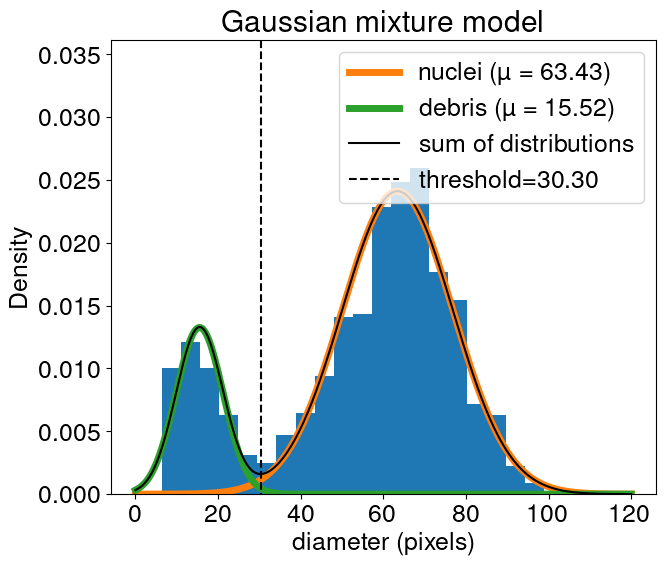

In [10]:
fig, ax = plt.subplots(figsize=(7,6))
ax.hist(diameters1, bins=20, density=True)
nuc_id = np.argmax(means1)
ax.plot(x, gcs1[nuc_id], label="nuclei (µ = %.2f)" %d_cells1, lw=5)

if len(local_minima)!=0:
    debris_id = np.argmin(means1)
    ax.plot(x, gcs1[debris_id], label="debris (µ = %.2f)" %d_debris1, lw=5)
    ax.plot(x, gc1, c='k', label="sum of distributions")
    ax.plot(x[id1]*np.ones(100), np.linspace(-0.1,np.max(gc1)+0.5*np.max(gc1), 100), ls='--',c='k', label="threshold=%.2f" %x[id1])
    ax.set_ylim(0, np.max(gc1))
    plt.ylim(0, np.max(gc1)+0.5*np.max(gc1))

ax.set_xlabel("diameter (pixels)")
ax.set_ylabel("Density")
plt.legend()
plt.title("Gaussian mixture model")
plt.tight_layout()
plt.savefig(path_figures+"debris_th_1.svg", bbox_inches='tight')
plt.show()

Compute gaussian mixture for second case `D2`

In [11]:
# Fit a GMM with 2 components to the data
gmm2 = GaussianMixture(n_components=2)
gmm2.fit(np.array(diameters2).reshape(-1, 1))

# Get means and standard deviations of the two components
means2 = gmm2.means_.flatten()
stds2 = np.sqrt(gmm2.covariances_).flatten()

gcs2 = []
d_cells2 =np.max(means2)
d_debris1 = np.min(means2)
for i in range(len(means2)):
    gcs2.append(norm.pdf(x, means2[i], stds2[i])*gmm2.weights_[i])

gc2 = np.sum(gcs2, axis=0)
local_minima = argrelextrema(gc2, np.less)[0]
if len(local_minima) == 0:
    th2 = 0
else:
    id2 = local_minima[0]
    th2 = x[id2]

Now print and display the resulting distributions

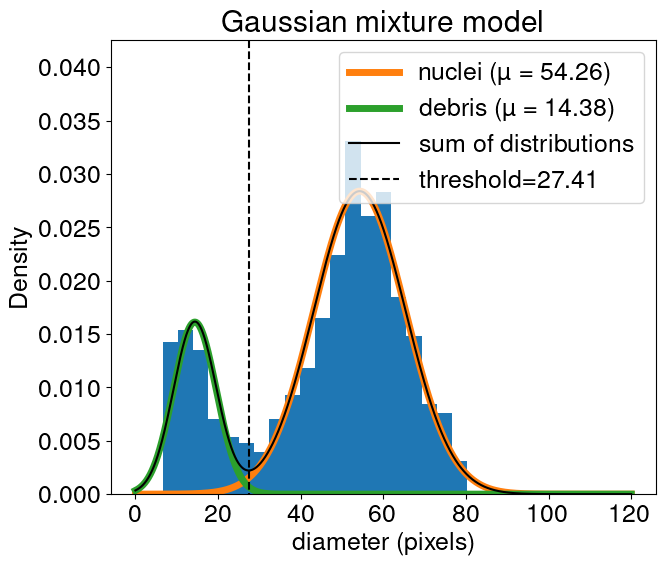

In [12]:
fig, ax = plt.subplots(figsize=(7,6))
ax.hist(diameters2, bins=20, density=True)
nuc_id = np.argmax(means2)
ax.plot(x, gcs2[nuc_id], label="nuclei (µ = %.2f)" %d_cells2, lw=5)

if len(local_minima)!=0:
    debris_id = np.argmin(means2)
    ax.plot(x, gcs2[debris_id], label="debris (µ = %.2f)" %d_debris1, lw=5)
    ax.plot(x, gc2, c='k', label="sum of distributions")
    ax.plot(x[id2]*np.ones(100), np.linspace(-0.1,np.max(gc2)+0.5*np.max(gc2), 100), ls='--',c='k', label="threshold=%.2f" %x[id2])
    ax.set_ylim(0, np.max(gc2))
    plt.ylim(0, np.max(gc2)+0.5*np.max(gc2))

ax.set_xlabel("diameter (pixels)")
ax.set_ylabel("Density")
plt.legend()
plt.title("Gaussian mixture model")
plt.tight_layout()
plt.savefig(path_figures+"debris_th_2.svg", bbox_inches='tight')
plt.show()

Check if Kernel Density Estimation fits better for the `D1` case.

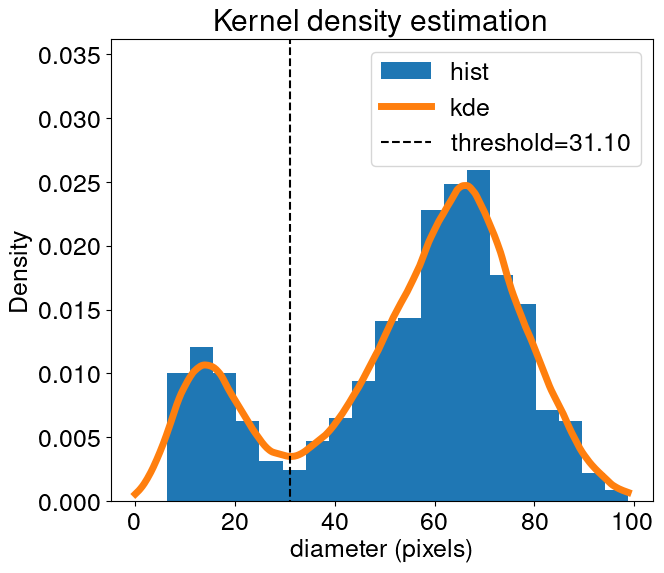

In [13]:
from sklearn.neighbors import KernelDensity
from scipy.signal import argrelextrema
fig, ax = plt.subplots(figsize=(7,6))

x = np.arange(0, step=0.1, stop=np.max(diameters1))
bw = 10.0
modelo_kde = KernelDensity(kernel='linear', bandwidth=bw)
modelo_kde.fit(X=np.array(diameters1).reshape(-1, 1))
densidad_pred = np.exp(modelo_kde.score_samples(x.reshape((-1,1))))
local_minima = argrelextrema(densidad_pred, np.less)[0]

ax.hist(diameters1, bins=20, density=True, label="hist")
ax.plot(x, densidad_pred, lw=5, label="kde")
ax.plot(x[local_minima[0]]*np.ones(100), np.linspace(-0.1,np.max(gc1)+0.5*np.max(gc1), 100), ls='--',c='k', label="threshold=%.2f" %x[local_minima[0]])
ax.legend()
ax.set_xlabel("diameter (pixels)")
ax.set_ylim(0, np.max(gc1)+0.5*np.max(gc1))
ax.set_title("Kernel density estimation")
ax.set_ylabel("Density")

plt.savefig(path_figures+"debris_th_3.svg", bbox_inches='tight')
plt.show()